In [1]:
%reload_ext autoreload
%autoreload 2

from collections import OrderedDict
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from functools import partial
import h5py
import numpy as np
import time
import xarray as xr
from itertools import groupby
import matplotlib.pyplot as plt
import matplotlib.patches as patches


from karabo_data import open_run, DataCollection
from calibration import dark_offset, module_roi_intensity, parse_ids

# Evaluate dark for all modules in parallel and store in file


In [2]:
proposal = 900089
dark_run_nr = 49

modules = "0:16"
pulse_ids = ":"

# List of modules
module_numbers = parse_ids(modules)
module_numbers

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [4]:
# Store dark data in dark_data dictionary
# dark_data = {modno:data}

dark_data = {}

_dark_eval = partial(dark_offset, 
                     proposal,
                     dark_run_nr,
                     pulse_ids=pulse_ids,
                     dettype='LPD')

t0 = time.perf_counter()

with ProcessPoolExecutor(max_workers=len(module_numbers)) as executor:
    for modno, ret in zip(module_numbers, executor.map(_dark_eval, module_numbers)):
        dark_data[modno] = ret
        
print(f"Time to evaluate dark offset: {time.perf_counter() - t0}")     

Time to evaluate dark offset: 119.22348740324378


<IPython.core.display.Javascript object>


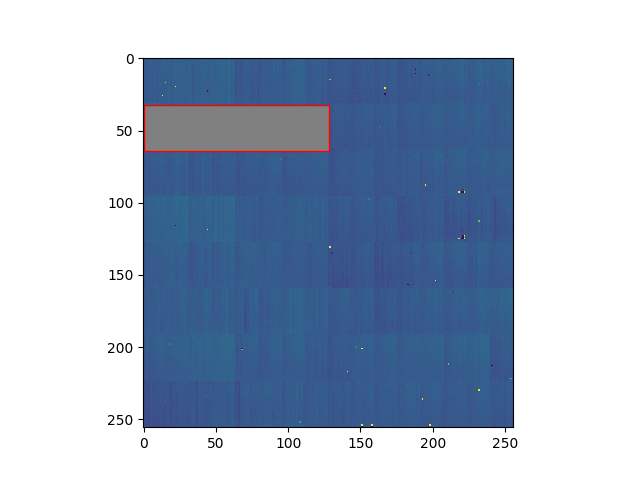

In [5]:
%matplotlib notebook

fig, ax = plt.subplots(1,1)

agipd_roi = [32, 64, 0, 128]
x, y = agipd_roi[2], agipd_roi[0]
dx, dy = agipd_roi[3] - agipd_roi[2], agipd_roi[1] - agipd_roi[0]

rect = patches.Rectangle((x, y), dx, dy, linewidth=1, edgecolor='r', facecolor='gray')

ax.add_patch(rect)

plt.imshow(dark_data[15][2])

# Write dark data to file

In [6]:
dark_data_file = "/home/kamile/Desktop/dark_data.h5"

with h5py.File(dark_data_file, "w") as f:
    g = f.create_group(f"entry_1/instrument")
    for modno, data in dark_data.items():
        if data is not None:
            h = g.create_group(f"module_{modno}")
            h.create_dataset('data', data=data)

# ROI intensities vs delay scan

        def module_roi_intensity(module_number, proposal, run, *,
                         pulse_ids=None, rois=None,
                         dettype='AGIPD', dark_run=None,
                         use_xgm=None):
            """ Process Dark data

            Parameters
            ----------
            module_number: str, int
                Channel number between 0, 15
            proposal: str, int
                A proposal number, such as 2012, '2012', 'p002012', or a path such as
                '/gpfs/exfel/exp/SPB/201701/p002012'.
            run: str, int
                A run number such as 243, '243' or 'r0243'.
            pulse_ids: str
                For eg. ":" to select all pulses in a train
                        "start:stop:step" to select indices with certain step size
                        "1,2,3" comma separated pulse index to select specific pulses
                        "1,2,3, 5:10" mix of above two
                Default: all pulses ":"
            rois: list
                [x0, x1, y0, y1]
            dettype: str
                "AGIPD", "LPD"
            dark_run: (numpy.ndarray) or dict optional
                dark_data shape (n_pulses, slow_scan, fast_scan)
                dark_run[module_number] of shape (n_pulses, slow_scan, fast_scan)
                Default: None,
                If provided dark data will be subtracted from images
            use_xgm: str
                XGM source name to be used to normalize data.
                For eg: "SPB_XTD9_XGM/DOOCS/MAIN:output"

            Return
            ------
            out: xarray
                The first axis of the returned data will be labelled with the trainId
                Shape of numpy array: (n_trains, n_pulses)
            """

# Read dark data from files and store in dictionary dark_run

In [7]:
dark_data_file = "/home/kamile/Desktop/dark_data.h5"

dark_run = {}

import re
def iterate(name, node):
    if isinstance(node, h5py.Dataset):
        m = re.search("(.+)module_(.+)/data", name)
        if m is not None:
            dark_run[m.group(2)] = node[:]

with h5py.File(dark_data_file, 'r') as f:
    f.visititems(iterate)

dark_run.keys()

dict_keys(['1', '11', '12', '13', '14', '15', '2', '3', '4', '6', '7', '8', '9'])

# Evaluate dark subtracted ROI intensities

In [ ]:
# Store roi intensities in roi_intensities dictionary

roi_intensities = {}

run = 56

_roi_intensity_eval = partial(module_roi_intensity, 
                              proposal=proposal,
                              run=run,
                              pulse_ids="0:11",
                              rois=[32, 64, 0, 128],
                              dettype='LPD',
                              dark_run=dark_run,
                              use_xgm="SPB_XTD9_XGM/DOOCS/MAIN:output")

t0 = time.perf_counter()

with ProcessPoolExecutor(max_workers=len(dark_run.keys())) as executor:
    for modno, ret in zip(
        dark_run.keys(), executor.map(
            _roi_intensity_eval, dark_run.keys())):
        roi_intensities[modno] = ret
        
print(f"Time to evaluate roi intensities: {time.perf_counter() - t0}")

# Get delay data

In [ ]:
delay_src = "FXE_RR_SYS/TSYS/UTC-1-S3"
delay_prop = "backTrg3.delay.value"

delay_data = {}

run = open_run(900089, 56) # proposal, run
# get delay data: xarray
delay_data = run.get_array(delay_src, delay_prop)
delay_data = delay_data.expand_dims('dim_1', axis=1)

delay_data

# Plot delay data and roi_intensities

In [ ]:
import  matplotlib.pyplot as plt
%matplotlib notebook


for modno in sorted(dark_run.keys(), key=lambda x: int(x)):
    if roi_intensities[modno] is not None:
        fig, ax = plt.subplots(1, 1)
        # Align delay and ROI intensities along the trainIds
        roi_int, delay = xr.align(roi_intensities[modno], delay_data)
        # Evaluate MEAN and STD for a given delay
        for pulse in range(roi_intensities[modno].shape[-1]):
            s = list(zip(delay[:, 0].values, roi_int[:, pulse].values))
            roi_int_avg = []
            roi_int_std = []
            dl = []
            for key, group in groupby(sorted(s), lambda x: x[0]):
                x, y = zip(*group)
                avg, std = np.mean(np.array(y)), np.std(np.array(y))
                roi_int_avg.append(avg)
                roi_int_std.append(std)
                dl.append(x[0])        

#             ax.errorbar(delay, roi_int_avg, yerr=roi_int_std, uplims=True, lolims=True)
            ax.plot(dl, roi_int_avg, '-o', label=f"Pulse index: {pulse}")
        ax.set_xlabel("Delay")
        ax.set_ylabel(f"ROI intensity")
        ax.set_title(f"Module number {modno}")
        ax.legend()